# Exercise 4
---

In [17]:
import seaborn as sbn
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
sbn.set()

# *Step 1: Simulate blocking system*

In [18]:
def blocking_system(arrival_intensity=1, mean_service_time=8, num_servers=10, n=10000, arrival_mode='poisson', service_mode='exponential', service_params={}):
    time_system = 0
    servers = np.zeros(num_servers)
    blocked = 0  # Counter of number of blocked
    busy_servers = np.zeros(n, dtype=int)

    for i in range(n):
        time_arrival = sample_arrival_time(arrival_mode, arrival_intensity)
        time_system += time_arrival

        min_server_idx = np.argmin(servers)
        time_service = sample_service_time(service_mode, mean_service_time, service_params)

        if time_system >= servers[min_server_idx]:
            servers[min_server_idx] = time_system + time_service
        else:
            blocked += 1

        busy_servers[i] = np.sum(servers > time_system)

    blocked_fraction = blocked / n
    return blocked_fraction, busy_servers  # Return both metrics

def sample_arrival_time(mode, intensity):
    if mode == 'poisson':
        return stats.expon.rvs(scale=intensity)
    elif mode == 'erlang':
        return stats.erlang.rvs(a=2, scale=intensity / 2)
    elif mode == 'hyper':
        return rvs_hyperexponential(p=0.8, lambda_1=0.8333, lambda_2=5.0)
    raise ValueError('Wrong arrival mode specified!')

def sample_service_time(mode, mean, params):
    if mode == 'exponential':
        return stats.expon.rvs(scale=mean)
    elif mode == 'constant':
        return mean
    elif mode == 'pareto':
        return rvs_pareto(mean_=mean, k=params.get('k'))
    elif mode == 'normal':
        val = stats.norm.rvs(loc=mean, scale=params.get('s'))
        return max(val, 0)
    raise ValueError('Wrong service mode specified')

def rvs_hyperexponential(p = 0.8, lambda_1 = 0.83, lambda_2 = 5.0, size = 1):    
    choices = stats.binom.rvs(p = 1 - p, n = 1, size = size)
    results = np.zeros(size)

    for i, choice in enumerate(choices):
        if choice == 0:
            results[i] =  stats.expon.rvs(scale = 1 / lambda_1, size = 1)[0]
        else:
            results[i] = stats.expon.rvs(scale = 1 / lambda_2, size = 1)[0]

    return results

def rvs_pareto(mean_=8, k=1.05, size=1):
    beta = mean_ * (k - 1) / k
    U = np.random.uniform(0, 1, size=size)
    return beta * (U ** (-1 / k))

def confidence_interval(vals, alpha=0.05):
    vals = np.array(vals) if type(vals) != np.ndarray else vals
    n = len(vals)
    mean_ = np.mean(vals)
    std_error = np.sqrt( 1 / (n - 1) * np.sum((vals - mean_) ** 2))
    t = stats.t.ppf(1 - (alpha / 2), df = n - 1 )
    return mean_ - t * std_error, mean_ + t * std_error

def analytical_blocking_system(arrival_intensity=1, mean_service_time=8, num_servers=10):
    lambda_ = arrival_intensity
    m = num_servers
    A = lambda_ * mean_service_time
    temp = np.array([A ** i / math.factorial(i) for i in range(m + 1)])
    B = temp[-1] / temp.sum()
    return B

Calculate the analytical solution and evaluate it against the confidence interval of the simulated results.

In [19]:
def simulate_blocking_systems(num_simulations=10):
    results = [blocking_system() for _ in range(num_simulations)]
    blocking_fractions = [result[0] for result in results]
    busy_servers = results[0][1]  # Use busy servers from the first simulation for plotting
    return blocking_fractions, busy_servers

def compute_confidence_interval(values):
    return confidence_interval(values)

def get_analytical_blocking_fraction():
    return analytical_blocking_system()

# Run simulations and capture busy_servers for plotting
simulated_fractions, busy_servers = simulate_blocking_systems()

# Confidence interval function remains the same
# Analytical calculation function remains the same
# Compute the confidence interval for the simulated data
confidence = compute_confidence_interval(simulated_fractions)

# Calculate the analytical blocked fraction
analytical_fraction = get_analytical_blocking_fraction()

# Output results using formatted strings
print(f"Confidence Interval for Simulated Blocking Rates: [{confidence[0] * 100:.2f}%, {confidence[1] * 100:.2f}%]")
print(f"Estimated Blocking Rate Based on Analytical Calculations: {analytical_fraction * 100:.2f}%")

Confidence Interval for Simulated Blocking Rates: [11.54%, 13.73%]
Estimated Blocking Rate Based on Analytical Calculations: 12.17%


Analytical solution falls within the confidence interval of the simulated results, suggesting that the simulation is functioning effectively. Additionally, by examining the number of busy servers in the simulation's steady state at each arrival, we can assess the simulation's accuracy and identify any potential errors.

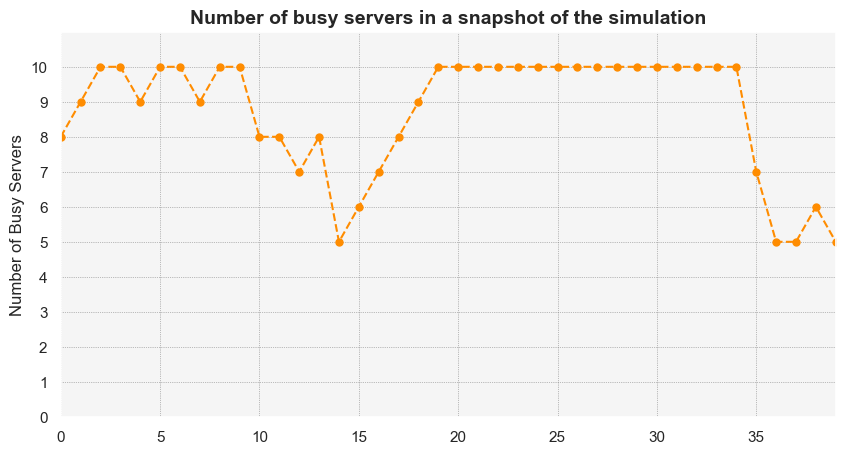

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(busy_servers[5000:5040], linestyle='--', marker='o', color='darkorange', markersize=5)

ax.set_xticks(np.arange(0, 41, 5))  # Setting x-ticks every 5 units
ax.set_yticks(np.arange(0, 11, 1))  # Setting y-ticks every 1 unit

ax.set_ylim(0, 11)
ax.set_xlim(0, 39)

ax.grid(True, linestyle=':', linewidth=0.5, color='grey')

ax.set_title('Number of busy servers in a snapshot of the simulation', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Busy Servers', fontsize=12)

ax.set_facecolor('whitesmoke')

plt.show()

# *Step 2: Experiment with different distributions of arrival time*

Now we run the simulation for all of the three arrival functions (poisson, erlang and hyper exponential) 10 times and report the results of confidence interval of the blocked fraction.

In [21]:
def compare_arrival_mode_performance():
    num_rounds = 10

    print('Evaluating blocked fraction for all arrival fucntions')

    # Iterate through each arrival mode and perform simulations
    for mode in ['poisson', 'erlang', 'hyper']:
        block_sims = np.zeros(num_rounds)  # Initialize an array to store blocked fractions

        # Perform the simulation rounds
        for r in range(num_rounds):
            blocked_fraction, _ = blocking_system(arrival_mode=mode)  # Assume this returns a scalar and any other value
            block_sims[r] = blocked_fraction  # Directly store the scalar value

        # Calculate the confidence interval for the blocked fractions
        conf_int = confidence_interval(block_sims, alpha=0.05)
        print(f'Arrival Mode: {mode}')
        print(f'Confidence Interval = [{conf_int[0] * 100:.2f}%, {conf_int[1] * 100:.2f}%]')


compare_arrival_mode_performance()

Evaluating blocked fraction for all arrival fucntions
Arrival Mode: poisson
Confidence Interval = [11.41%, 12.96%]
Arrival Mode: erlang
Confidence Interval = [8.17%, 10.26%]


/var/folders/k2/mm5423fs7px5769yh4t8lg580000gn/T/ipykernel_34840/3349457181.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  servers[min_server_idx] = time_system + time_service


Arrival Mode: hyper
Confidence Interval = [12.48%, 15.66%]


For the Erlang distribution, we select parameters $k = 2 $ and $\lambda = \frac{1}{2}$ to yield results that diverge from those produced by the exponential distribution. It's observed that the confidence interval for the blocked fraction is notably lower for the Erlang distribution compared to other distributions, whereas the hyperexponential distribution typically shows the highest estimates for the blocked fraction. Analyzing histograms of the sampling distribution can provide insights into the reasons behind these variations.

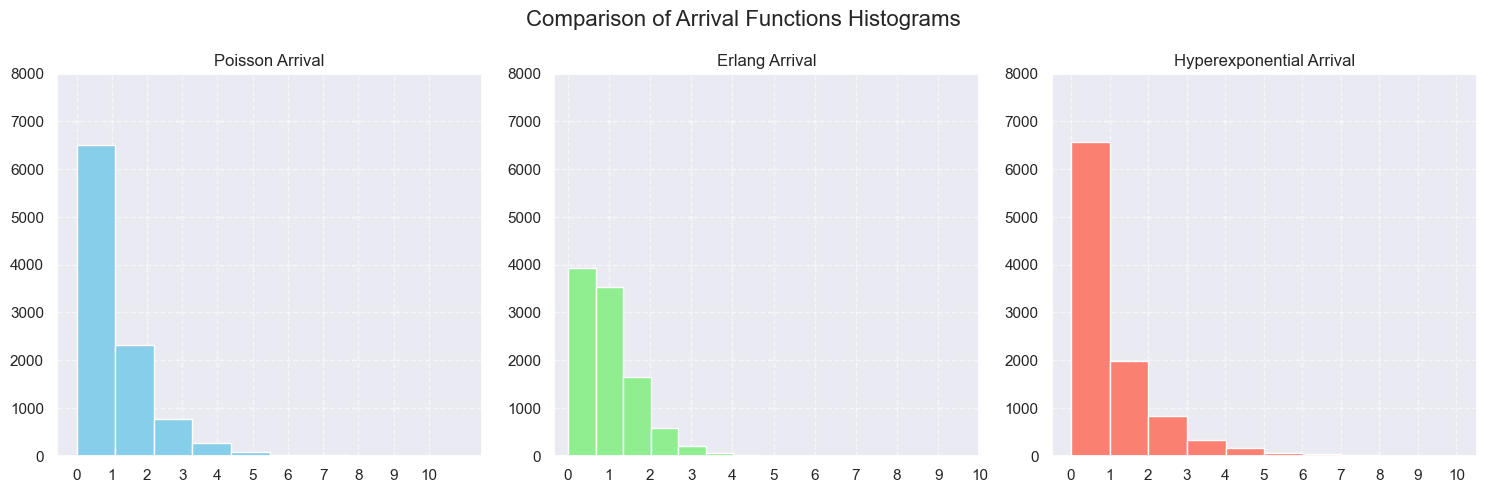

In [22]:
# Sample data
n_sample = 10000
poisson_data = stats.expon.rvs(scale=1, size=n_sample)
erlang_data = stats.erlang.rvs(a=2, scale=1/2, size=n_sample)
hyperexp_data = rvs_hyperexponential(p = 0.8, lambda_1 = 0.8333, lambda_2 = 5.0, size = n_sample)

n_bins = 10
n_sample = 10000

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

# Colors for each histogram
colors = ['skyblue', 'lightgreen', 'salmon']
titles = ['Poisson Arrival', 'Erlang Arrival', 'Hyperexponential Arrival']

# Plotting each histogram
for i, data in enumerate([poisson_data, erlang_data, hyperexp_data]):
    ax[i].hist(data, bins=n_bins, color=colors[i], edgecolor='white')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(np.arange(0, 11, 1))
    ax[i].set_ylim(0, 8000)
    ax[i].grid(True, linestyle='--', alpha=0.6)  # Adding a light grid for better reading of the scale

fig.suptitle('Comparison of Arrival Functions Histograms', fontsize=16)
plt.tight_layout(pad=1.0)  # Adjust spacing to prevent clipping of title/labels
plt.show()

Hyperexponential distribution plot shows that arrival times are less than one time unit almost 70% of the time, contributing to the highest blocked fraction observed in this sampling distribution. 

Erlang distribution shows a more uniform spread of arrival times, allowing servers more opportunity to finish tasks before the arrival of the next unit.

# *Step 3: Experiment with different service-time distributions with the same mean*

We conducted a series of simulations, running each distribution ten times to sample service times, and then calculated the 95% confidence interval for the blocked fraction. This approach helps to statistically quantify the variability and reliability of the blocked fraction across different trials, providing a robust measure of performance under each distribution scenario.

In [23]:
def run_simulation(mode, params, rounds=10):
    results = np.zeros(rounds)
    for j in range(rounds):
        results[j], _ = blocking_system(service_mode=mode, service_params=params)
    return results

def display_results(mode, params, results):
    conf_interval = confidence_interval(results, alpha=0.05)
    print(f"Service Mode: {mode}, Params: {params}, Confidence Interval: [{conf_interval[0] * 100:.2f}%, {conf_interval[1] * 100:.2f}%]")

def experiment_service_mode_distributions():
    service_modes = ['exponential', 'constant', 'pareto', 'pareto', 'normal']
    service_params = [{}, {}, {'k': 1.05}, {'k': 2.05}, {'s': 2}]

    print('Blocked fraction values of different service modes')
    
    for index, mode in enumerate(service_modes):
        results = run_simulation(mode, service_params[index])
        display_results(mode, service_params[index], results)

experiment_service_mode_distributions()

Blocked fraction values of different service modes
Service Mode: exponential, Params: {}, Confidence Interval: [10.95%, 13.72%]
Service Mode: constant, Params: {}, Confidence Interval: [11.34%, 13.05%]


/var/folders/k2/mm5423fs7px5769yh4t8lg580000gn/T/ipykernel_34840/3349457181.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  servers[min_server_idx] = time_system + time_service


Service Mode: pareto, Params: {'k': 1.05}, Confidence Interval: [-0.04%, 0.17%]
Service Mode: pareto, Params: {'k': 2.05}, Confidence Interval: [10.97%, 13.71%]
Service Mode: normal, Params: {'s': 2}, Confidence Interval: [11.12%, 13.51%]


The outcomes observed across various service modes display comparable trends to those seen with different arrival times. Notably, the Pareto distribution with $k = 1.05$ results in an exceptionally low number of blocked customers. This anomaly is attributed to the distribution's characteristic of frequent very low service times combined with a sparse occurrence of extremely high values. Despite the mean being consistent with other distributions, its skew towards lower values allows the system to handle high service times without significantly impacting performance. This is feasible due to the abundance of servers, which effectively mitigates the potential for increased blockage. Conversely, the Pareto distribution with $k = 2$ and other service models exhibit more uniform confidence intervals for the blocked fraction, suggesting less variance in their impact.

Additionally, the confidence intervals for blocked fractions are smallest with the constant service time model, excluding the Pareto with $k = 1.05$. This consistency can be logically linked to the reduced variability inherent in a constant service time scenario, where each run yields similar outcomes, thus offering a more predictable and stable estimation of service metrics. This comparative analysis highlights how service time distributions influence system performance, particularly in environments requiring efficient management of variable service demands.

# *Step 4:  Compare differences in confidence intervals for prior tasks*

For detailed analysis and observations regarding the blocked fractions across various arrival and service distributions, please refer to Steps 1, 2 and 3. These sections provide comprehensive commentary on how different distribution parameters influence the probability of service blockages, illustrating the effects of statistical variability and system response under different operational conditions.

In [24]:
compare_arrival_mode_performance()

experiment_service_mode_distributions()

Evaluating blocked fraction for all arrival fucntions
Arrival Mode: poisson
Confidence Interval = [11.16%, 13.62%]
Arrival Mode: erlang
Confidence Interval = [8.01%, 10.48%]


/var/folders/k2/mm5423fs7px5769yh4t8lg580000gn/T/ipykernel_34840/3349457181.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  servers[min_server_idx] = time_system + time_service


Arrival Mode: hyper
Confidence Interval = [12.46%, 15.51%]
Blocked fraction values of different service modes
Service Mode: exponential, Params: {}, Confidence Interval: [10.50%, 13.50%]
Service Mode: constant, Params: {}, Confidence Interval: [10.86%, 12.98%]
Service Mode: pareto, Params: {'k': 1.05}, Confidence Interval: [-0.18%, 0.37%]
Service Mode: pareto, Params: {'k': 2.05}, Confidence Interval: [10.81%, 12.98%]
Service Mode: normal, Params: {'s': 2}, Confidence Interval: [11.27%, 13.41%]
